In [ ]:
from google.colab import files

# Upload your zipped dataset (example: gtsrb_dataset.zip)
uploaded = files.upload()


Saving traffic.zip to traffic.zip


In [ ]:
import zipfile

# Unzip the uploaded file
with zipfile.ZipFile('traffic.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


In [ ]:
import os

# List extracted files/folders
print(os.listdir('/content/'))


['.config', '__MACOSX', 'traffic.zip', 'traffic', 'sample_data']


In [ ]:
import pandas as pd

# Correct path for your file inside "traffic" folder
df = pd.read_csv("/content/traffic/Train.csv")
print("✅ CSV Loaded")
print(df.head())


✅ CSV Loaded
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import pandas as pd

# Load the CSV
df = pd.read_csv("/content/traffic/Train.csv")  # <-- Correct Colab path

IMG_SIZE = 32
images = []
labels = []

# Load and preprocess images
for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join("/content/traffic", row['Path'])  # <-- Correct Colab path
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    images.append(img)
    labels.append(row['ClassId'])

# Convert to numpy arrays
X = np.array(images) / 255.0  # Normalize between 0-1
y = to_categorical(np.array(labels))  # One-hot encode labels

# Split dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Preprocessing Done Successfully")
print("Training samples shape:", X_train.shape)
print("Validation samples shape:", X_val.shape)
print("Classes:", y_train.shape[1])


100%|██████████| 39209/39209 [00:09<00:00, 4075.03it/s]


✅ Preprocessing Done Successfully
Training samples shape: (31367, 32, 32, 3)
Validation samples shape: (7842, 32, 32, 3)
Classes: 43


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Multiply, GlobalAveragePooling2D, Reshape, Activation

# Custom attention block
def simple_attention(x):
    attn = GlobalAveragePooling2D()(x)
    attn = Dense(x.shape[-1], activation='softmax')(attn)
    attn = Reshape((1, 1, x.shape[-1]))(attn)
    return Multiply()([x, attn])

# Define the CNN model with attention
input_layer = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Add attention
x = simple_attention(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(43, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 8, 8, 64)  │          0 │ max_pooling2d_1[… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    524,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 43)        │      5,547 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 553,515 (2.11 MB)

 Trainable params: 553,515 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
checkpoint_path = "/content/best_model.keras"  # Optional: Can also just write "best_model.keras"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.1268 - loss: 3.3120 - val_accuracy: 0.5763 - val_loss: 1.4888
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5617 - loss: 1.5162 - val_accuracy: 0.7137 - val_loss: 0.9503
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6793 - loss: 1.0964 - val_accuracy: 0.7902 - val_loss: 0.7399
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7242 - loss: 0.9198 - val_accuracy: 0.8003 - val_loss: 0.6851
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7510 - loss: 0.8259 - val_accuracy: 0.8323 - val_loss: 0.5942
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7669 - loss: 0.7637 - val_accuracy: 0.8411 - val_loss: 0.5368
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7887 - loss: 0.6867 - val_accuracy: 0.8549 - val_loss: 0.4890
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8054 - loss: 0.6350 - val_accuracy: 

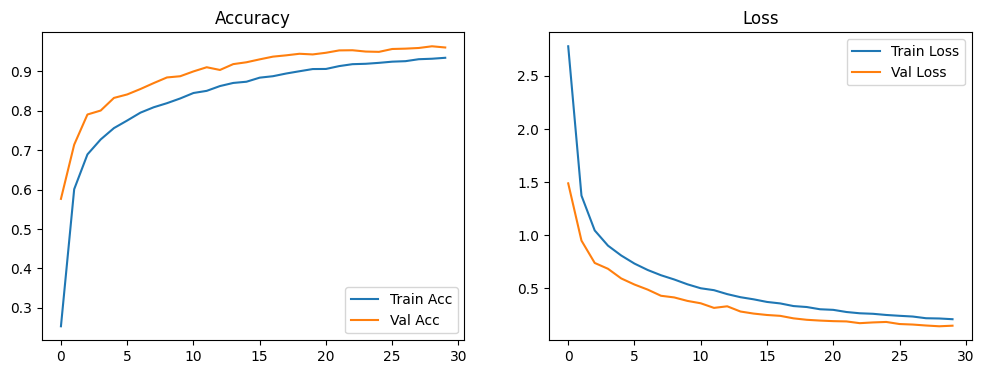

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
import pandas as pd

# Load Test CSV
test_df = pd.read_csv("/content/traffic/Test.csv")  # <-- Colab correct path
print("✅ Test.csv Loaded")
print("Total test samples:", len(test_df))


✅ Test.csv Loaded
Total test samples: 12630


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

test_images = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_path = os.path.join("/content/traffic", row['Path'])  # <-- Corrected path for Colab
    img = cv2.imread(img_path)
    img = cv2.resize(img, (32, 32))
    test_images.append(img)

# Convert to numpy array and Normalize
test_images = np.array(test_images) / 255.0

print("✅ Test Images Loaded and Normalized")
print("Test Images Shape:", test_images.shape)


100%|██████████| 12630/12630 [00:03<00:00, 3373.18it/s]


✅ Test Images Loaded and Normalized
Test Images Shape: (12630, 32, 32, 3)


In [ ]:
# Predict class probabilities
pred_probs = model.predict(test_images)

# Convert to predicted class index
pred_labels = np.argmax(pred_probs, axis=1)


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
submission = test_df.copy()
submission['Predicted'] = pred_labels

# Save only Path and Predicted columns
submission[['Path', 'Predicted']].to_csv("/content/gtsrb_predictions.csv", index=False)

print("✅ Predictions saved to gtsrb_predictions.csv")


✅ Predictions saved to gtsrb_predictions.csv


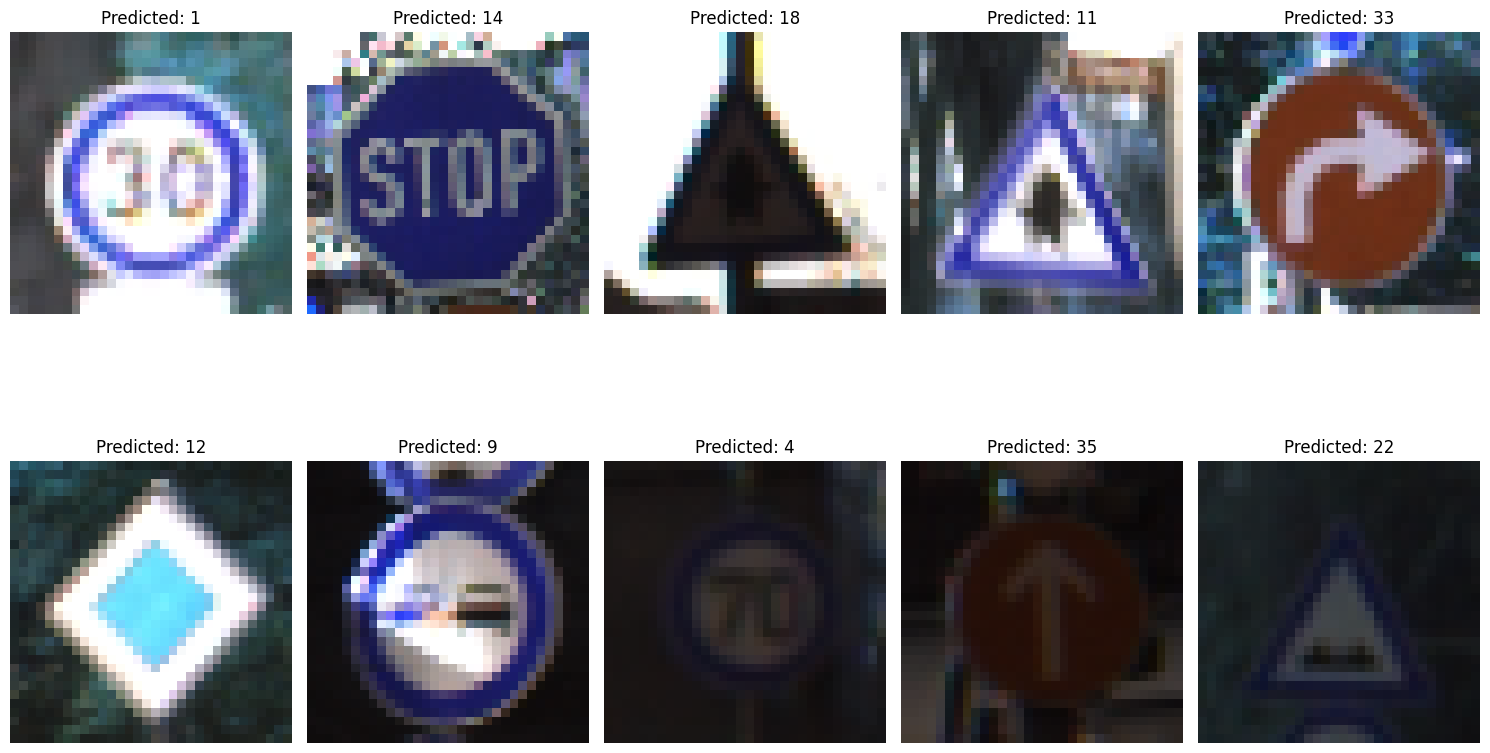

In [ ]:
import matplotlib.pyplot as plt
import random

# Mapping class IDs to labels (Optional: customize if needed)
class_labels = [str(i) for i in range(43)]  # Here just simple IDs

# Show 10 random predictions
plt.figure(figsize=(15, 10))
for i in range(10):
    idx = random.randint(0, len(test_images)-1)
    img = test_images[idx]
    pred = pred_labels[idx]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[pred]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Predicted: 31  | Actual: 31


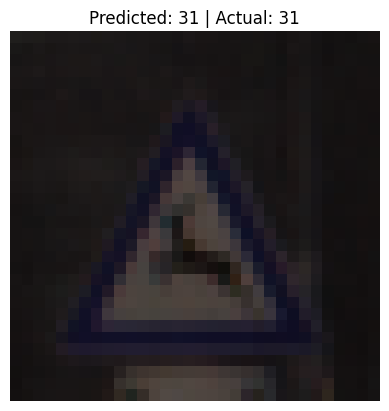

In [ ]:
# Get the true labels
actual = test_df['ClassId'].values  # True labels from Test.csv

# Pick a random image index
idx = random.randint(0, len(test_images)-1)

# Show prediction vs actual
print("Predicted:", pred_labels[idx], " | Actual:", actual[idx])

# Also show the image
import matplotlib.pyplot as plt

plt.imshow(test_images[idx])
plt.title(f"Predicted: {pred_labels[idx]} | Actual: {actual[idx]}")
plt.axis('off')
plt.show()


In [ ]:
# Dictionary: Class ID → Class Name
class_names = {
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)',
    9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield',
    14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road',
    23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work',
    26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing',
    32: 'End of all speed and passing limits', 33: 'Turn right ahead',
    34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right',
    37: 'Go straight or left', 38: 'Keep right', 39: 'Keep left',
    40: 'Roundabout mandatory', 41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}


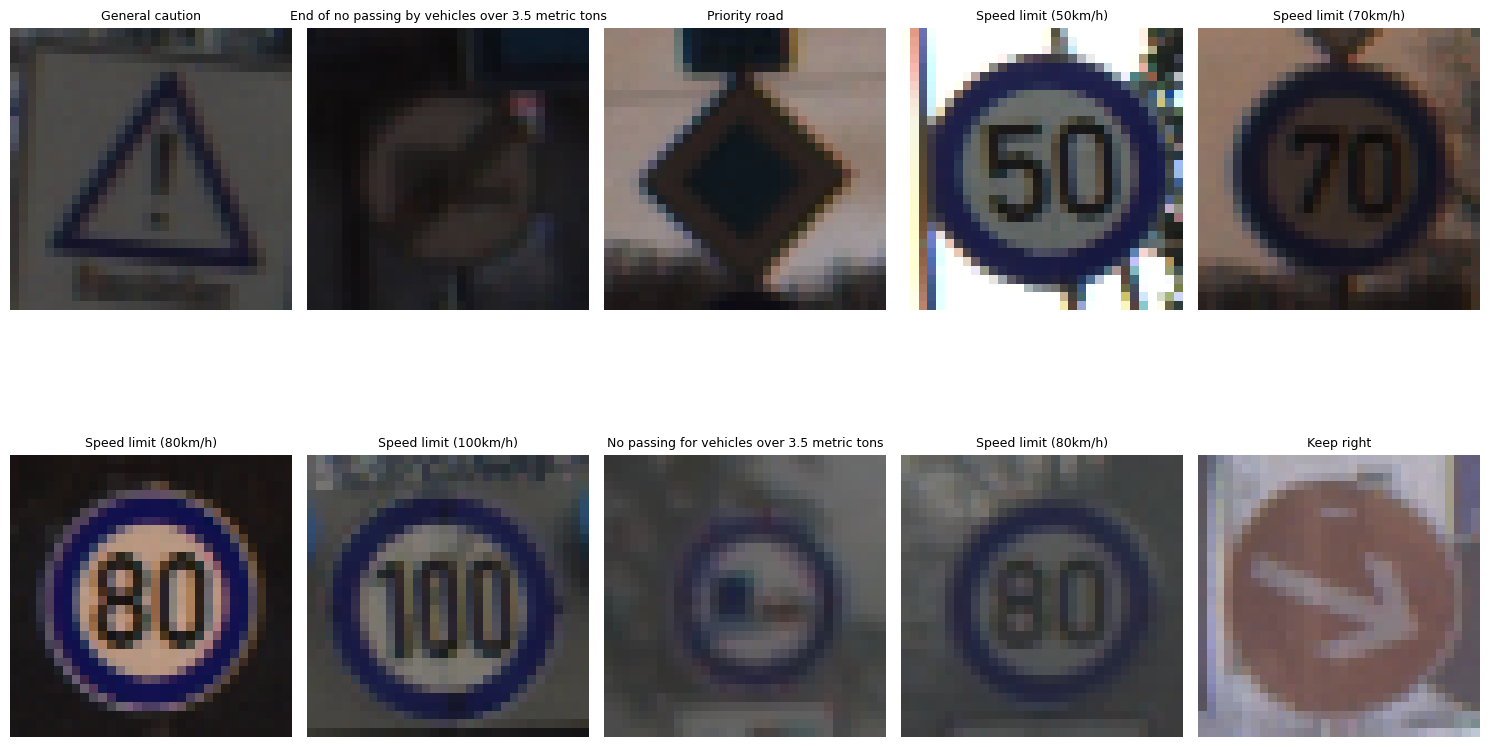

In [ ]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15, 10))
for i in range(10):
    idx = random.randint(0, len(test_images)-1)
    img = test_images[idx]
    pred_id = pred_labels[idx]
    pred_name = class_names[pred_id]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"{pred_name}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


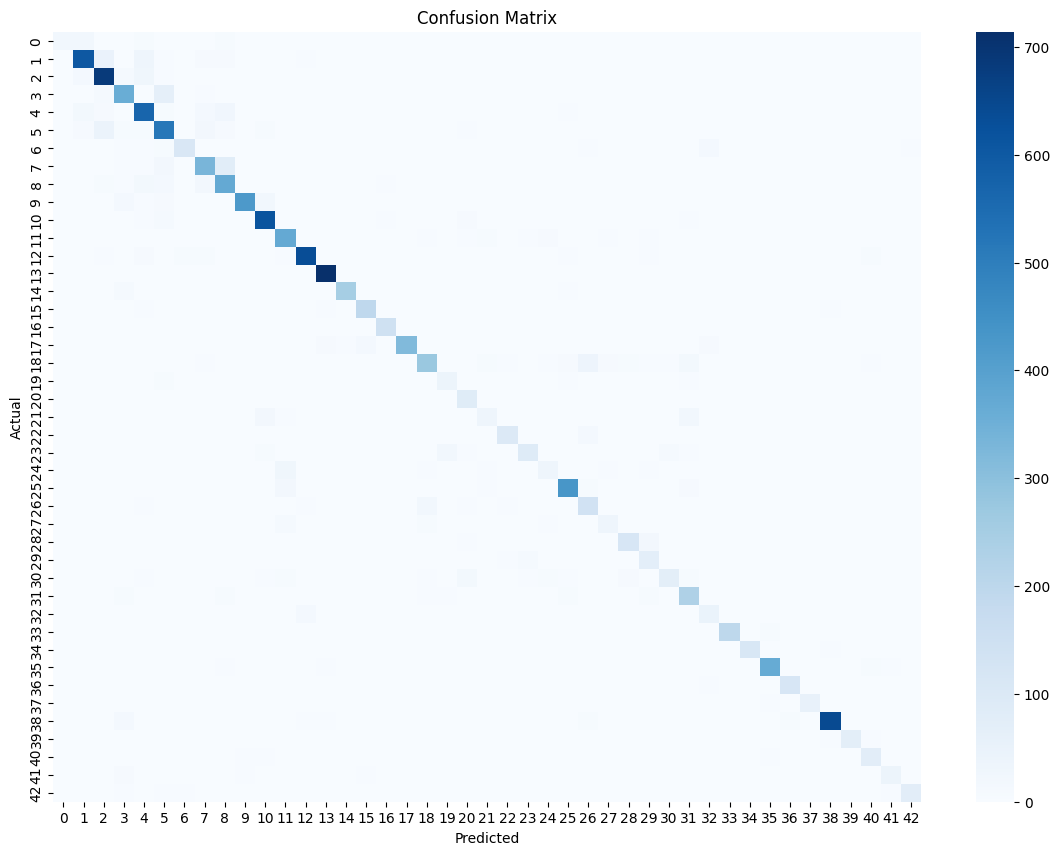

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# True and predicted labels
y_true = test_df['ClassId'].values
y_pred = pred_labels

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=[class_names[i] for i in range(43)])
print(report)

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.92      0.40      0.56        60
                              Speed limit (30km/h)       0.88      0.84      0.86       720
                              Speed limit (50km/h)       0.83      0.91      0.87       750
                              Speed limit (60km/h)       0.77      0.80      0.79       450
                              Speed limit (70km/h)       0.80      0.86      0.83       660
                              Speed limit (80km/h)       0.76      0.82      0.79       630
                       End of speed limit (80km/h)       0.90      0.73      0.80       150
                             Speed limit (100km/h)       0.78      0.74      0.76       450
                             Speed limit (120km/h)       0.71      0.83      0.77       450
                                        No passing       0.97      0.88      0.

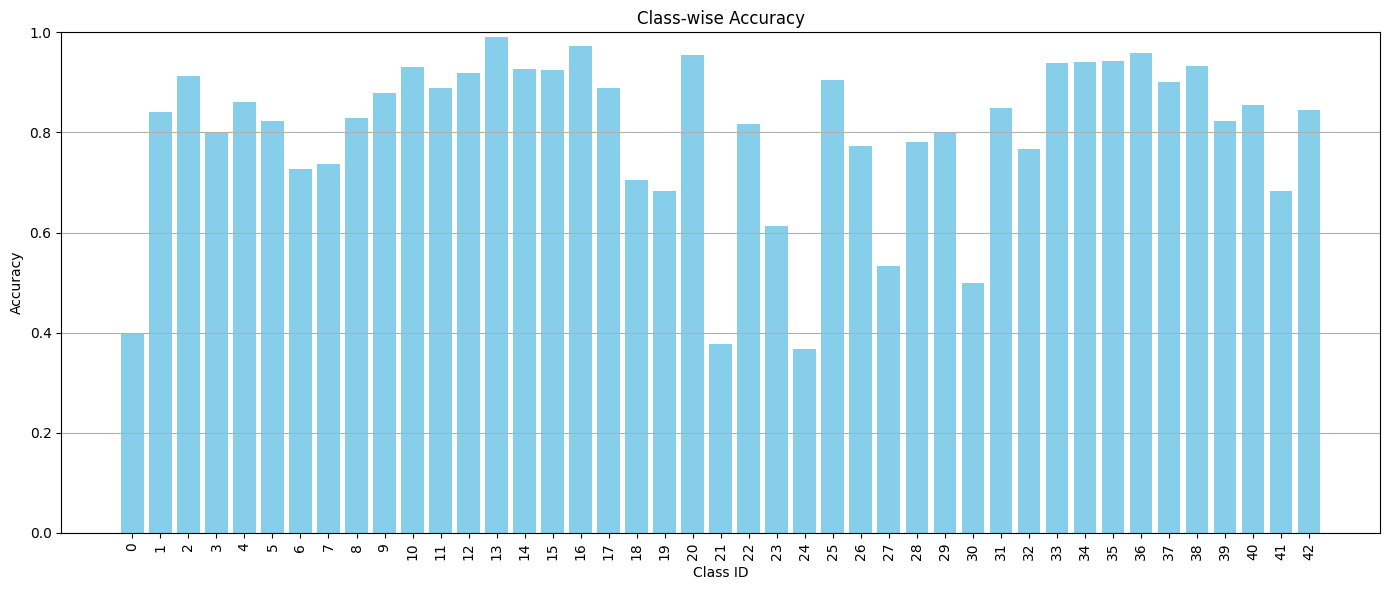

In [ ]:
from sklearn.metrics import accuracy_score

# Get true labels from Test.csv
y_true = test_df['ClassId'].values
y_pred = pred_labels

# Calculate per-class accuracy
class_accuracies = []
for i in range(43):
    idxs = (y_true == i)
    acc = accuracy_score(y_true[idxs], y_pred[idxs])
    class_accuracies.append(acc)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(range(43), class_accuracies, color='skyblue')
plt.xticks(range(43), [f"{i}" for i in range(43)], rotation=90)
plt.ylim([0, 1])
plt.title("Class-wise Accuracy")
plt.xlabel("Class ID")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


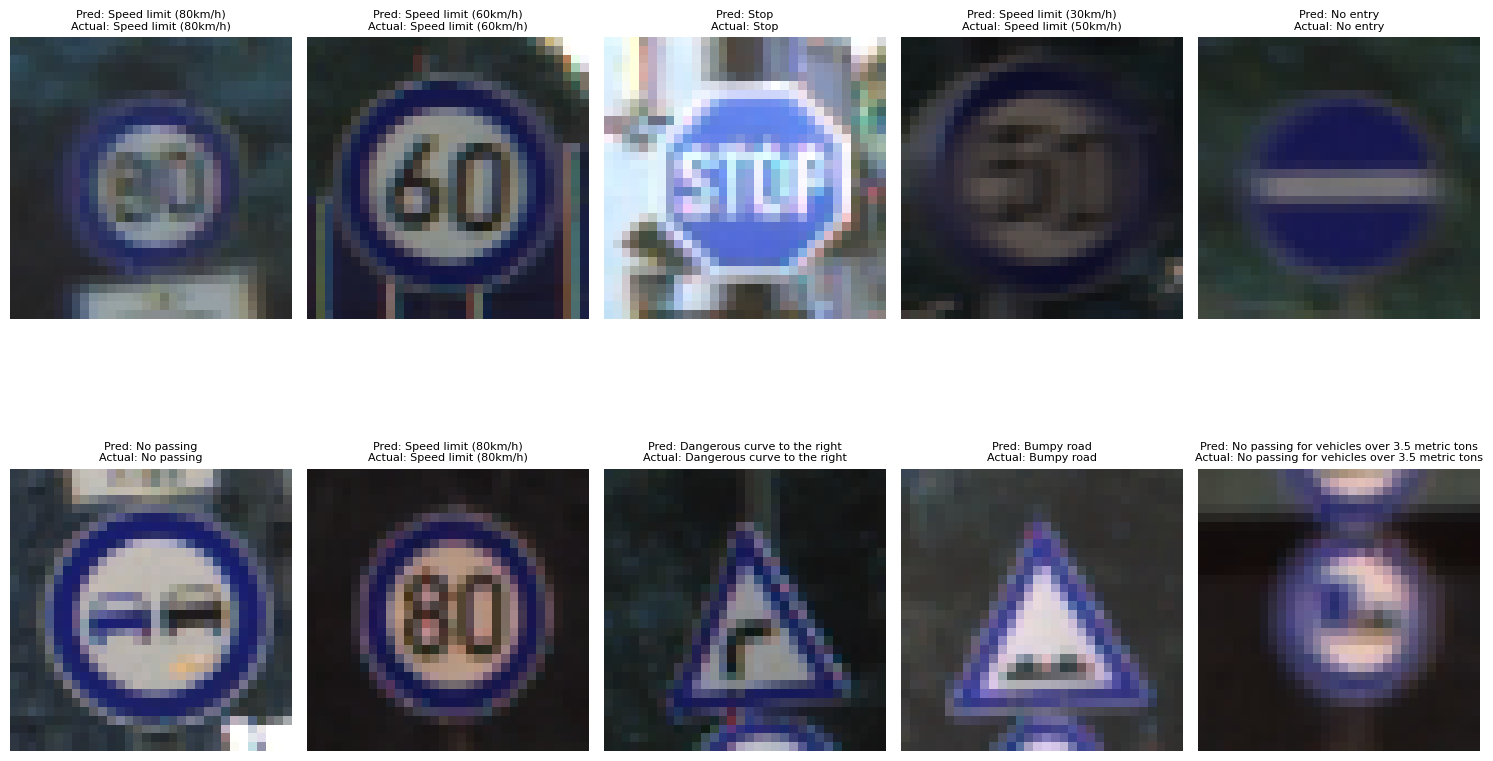

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(10):
    idx = random.randint(0, len(test_images)-1)
    img = test_images[idx]
    pred_id = pred_labels[idx]
    actual_id = actual[idx]

    pred_name = class_names[pred_id]
    actual_name = class_names[actual_id]

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {pred_name}\nActual: {actual_name}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


Squeeze-and-Excitation Attention Code

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply

# Squeeze-and-Excitation (SE) Attention Block
def se_attention(x, ratio=8):
    channel_axis = -1  # Tensorflow channels-last format
    filters = x.shape[channel_axis]

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(x)

    # Excitation: Dense → ReLU → Dense → Sigmoid
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    # Reshape to match original feature map
    se = Reshape((1, 1, filters))(se)

    # Multiply attention weights with input feature map
    x = Multiply()([x, se])
    return x


In [ ]:
# Your model

input_layer = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Replace with SE Attention
x = se_attention(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(43, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# SE Attention Block
def se_attention(x, ratio=8):
    filters = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([x, se])

# Build SE Attention Model
input_layer_se = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer_se)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = se_attention(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_se = Dense(43, activation='softmax')(x)

model_se = Model(inputs=input_layer_se, outputs=output_se)

model_se.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_se.summary()

# Train
history_se = model_se.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 64)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_7[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │        576 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 64)  │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 8, 8, 64)  │          0 │ max_pooling2d_7[… │
│ (Multiply)          │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4096)      │          0 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │    524,416 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 43)        │      5,547 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 550,451 (2.10 MB)

 Trainable params: 550,451 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.2590 - loss: 2.7537 - val_accuracy: 0.8066 - val_loss: 0.7070
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7524 - loss: 0.7725 - val_accuracy: 0.9319 - val_loss: 0.2748
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8759 - loss: 0.3977 - val_accuracy: 0.9486 - val_loss: 0.1794
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9207 - loss: 0.2519 - val_accuracy: 0.9726 - val_loss: 0.1054
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9417 - loss: 0.1838 - val_accuracy: 0.9799 - val_loss: 0.0834
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9541 - loss: 0.1478 - val_accuracy: 0.9825 - val_loss: 0.0665
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9582 - loss: 0.1334 - val_accuracy: 0.9861 - val_loss: 0.0546
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9671 - loss: 0.1077 - val_accuracy: 0

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Multiply, Reshape

# Simple Attention block
def simple_attention(x):
    attn = GlobalAveragePooling2D()(x)
    attn = Dense(x.shape[-1], activation='softmax')(attn)
    attn = Reshape((1, 1, x.shape[-1]))(attn)
    return Multiply()([x, attn])

# Build Simple Attention model
input_layer_simple = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer_simple)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = simple_attention(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_simple = Dense(43, activation='softmax')(x)

model_simple = Model(inputs=input_layer_simple, outputs=output_simple)

# Compile model
model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model_simple.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 8, 8, 64)  │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_9[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 64)  │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 8, 8, 64)  │          0 │ max_pooling2d_9[… │
│ (Multiply)          │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 4096)      │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │    524,416 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 43)        │      5,547 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 553,515 (2.11 MB)

 Trainable params: 553,515 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_simple = model_simple.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)


Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.1404 - loss: 3.2540 - val_accuracy: 0.5910 - val_loss: 1.5044
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5536 - loss: 1.5317 - val_accuracy: 0.7029 - val_loss: 0.9905
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6705 - loss: 1.1037 - val_accuracy: 0.7666 - val_loss: 0.7735
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7224 - loss: 0.9163 - val_accuracy: 0.8004 - val_loss: 0.6663
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7593 - loss: 0.7923 - val_accuracy: 0.8383 - val_loss: 0.5604
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7769 - loss: 0.7308 - val_accuracy: 0.8493 - val_loss: 0.5075
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8051 - loss: 0.6458 - val_accuracy: 0.8512 - val_loss: 0.5216
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8156 - loss: 0.6023 - val_accuracy: 0

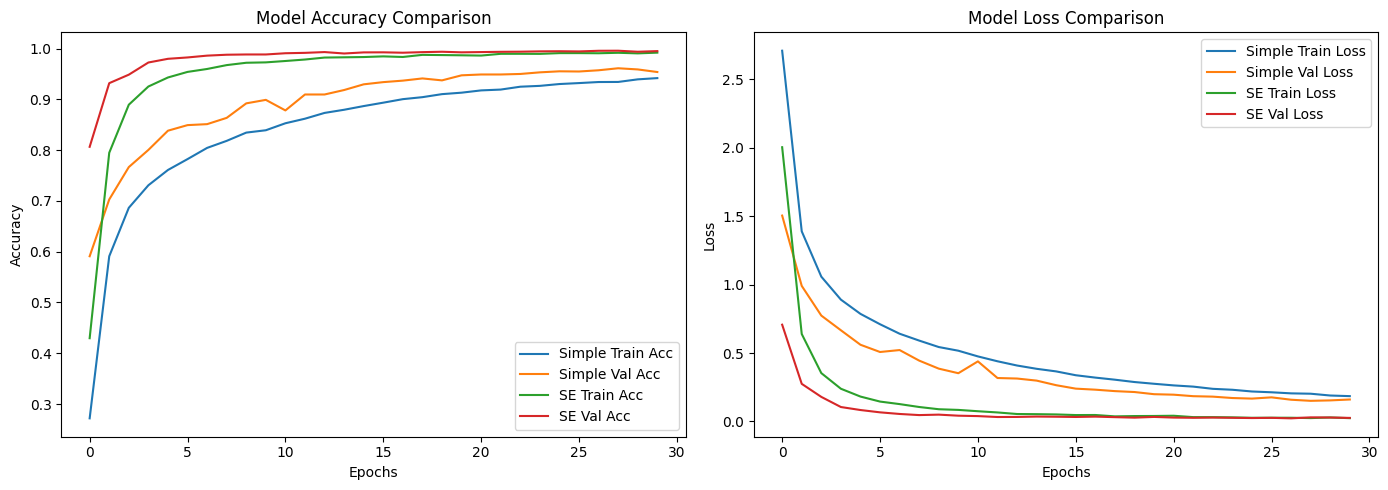

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy for both models
plt.figure(figsize=(14, 5))

# -----------------------
# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['accuracy'], label='Simple Train Acc')
plt.plot(history_simple.history['val_accuracy'], label='Simple Val Acc')
plt.plot(history_se.history['accuracy'], label='SE Train Acc')
plt.plot(history_se.history['val_accuracy'], label='SE Val Acc')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# -----------------------
# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['loss'], label='Simple Train Loss')
plt.plot(history_simple.history['val_loss'], label='Simple Val Loss')
plt.plot(history_se.history['loss'], label='SE Train Loss')
plt.plot(history_se.history['val_loss'], label='SE Val Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


CBAM Attention Block

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Add, Multiply, Reshape, Conv2D, Activation, Concatenate, Lambda

# CBAM Attention Block (Fixed Version)
def cbam_attention(x, ratio=8):
    channel = x.shape[-1]

    # ---- Channel Attention ----
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)

    avg_dense = Dense(channel // ratio, activation='relu')(avg_pool)
    avg_dense = Dense(channel)(avg_dense)

    max_dense = Dense(channel // ratio, activation='relu')(max_pool)
    max_dense = Dense(channel)(max_dense)

    channel_attention = Add()([avg_dense, max_dense])
    channel_attention = Activation('sigmoid')(channel_attention)

    channel_attention = Reshape((1, 1, channel))(channel_attention)
    x = Multiply()([x, channel_attention])

    # ---- Spatial Attention ----
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    spatial_attention = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])

    spatial_attention = Conv2D(1, (7,7), padding='same', activation='sigmoid')(spatial_attention)

    x = Multiply()([x, spatial_attention])

    return x


In [ ]:
# Build CBAM Attention model
input_layer_cbam = Input(shape=(32, 32, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer_cbam)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Apply CBAM Attention
x = cbam_attention(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_cbam = Dense(43, activation='softmax')(x)

model_cbam = Model(inputs=input_layer_cbam, outputs=output_cbam)

model_cbam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_cbam.summary()

# Train
history_cbam = model_cbam.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │        896 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 64)  │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_13… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ max_pooling2d_13… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 8)         │        520 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 64)        │        576 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │        576 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64)        │          0 │ dense_23[0][0],   │
│                     │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64)        │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 1, 64)  │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_6          │ (None, 8, 8, 64)  │          0 │ max_pooling2d_13… │
│ (Multiply)          │                   │            │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 8, 8, 1)   │          0 │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 8, 8, 1)   │          0 │ multiply_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 2)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 1)   │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 551,646 (2.10 MB)

 Trainable params: 551,646 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.2805 - loss: 2.6772 - val_accuracy: 0.8660 - val_loss: 0.4907
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8266 - loss: 0.5604 - val_accuracy: 0.9515 - val_loss: 0.1850
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9154 - loss: 0.2798 - val_accuracy: 0.9700 - val_loss: 0.1235
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9447 - loss: 0.1816 - val_accuracy: 0.9828 - val_loss: 0.0732
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9621 - loss: 0.1321 - val_accuracy: 0.9832 - val_loss: 0.0711
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9661 - loss: 0.1148 - val_accuracy: 0.9861 - val_loss: 0.0568
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9729 - loss: 0.0893 - val_accuracy: 0.9898 - val_loss: 0.0470
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9731 - loss: 0.0926 - val_accuracy: 

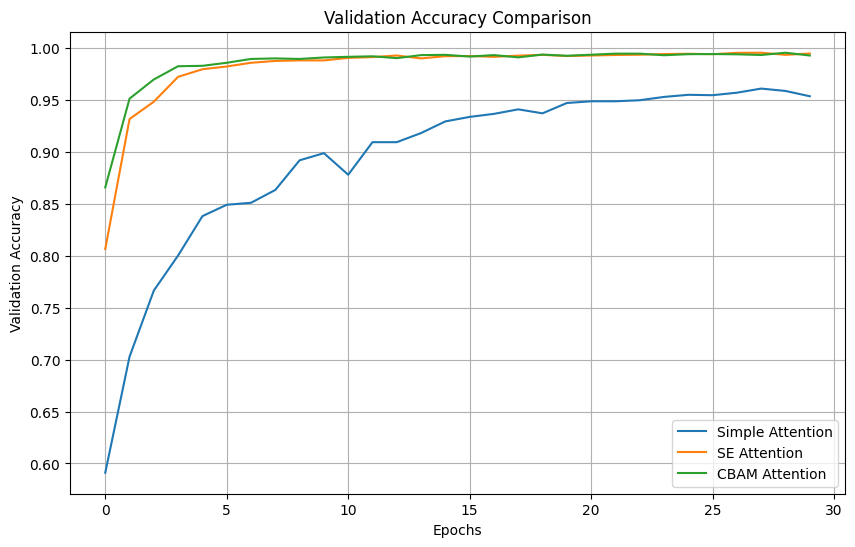

In [ ]:
import matplotlib.pyplot as plt

# Plot Validation Accuracy Comparison
plt.figure(figsize=(10, 6))

# Plot each model's Validation Accuracy
plt.plot(history_simple.history['val_accuracy'], label='Simple Attention')
plt.plot(history_se.history['val_accuracy'], label='SE Attention')
plt.plot(history_cbam.history['val_accuracy'], label='CBAM Attention')

# Labels and Title
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

# Add a Legend
plt.legend()

plt.grid(True)
plt.show()


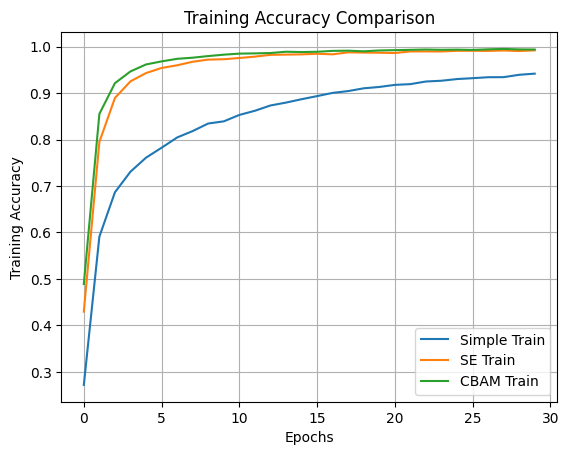

In [ ]:
# Training Accuracy Comparison (optional)
plt.plot(history_simple.history['accuracy'], label='Simple Train')
plt.plot(history_se.history['accuracy'], label='SE Train')
plt.plot(history_cbam.history['accuracy'], label='CBAM Train')
plt.legend()
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


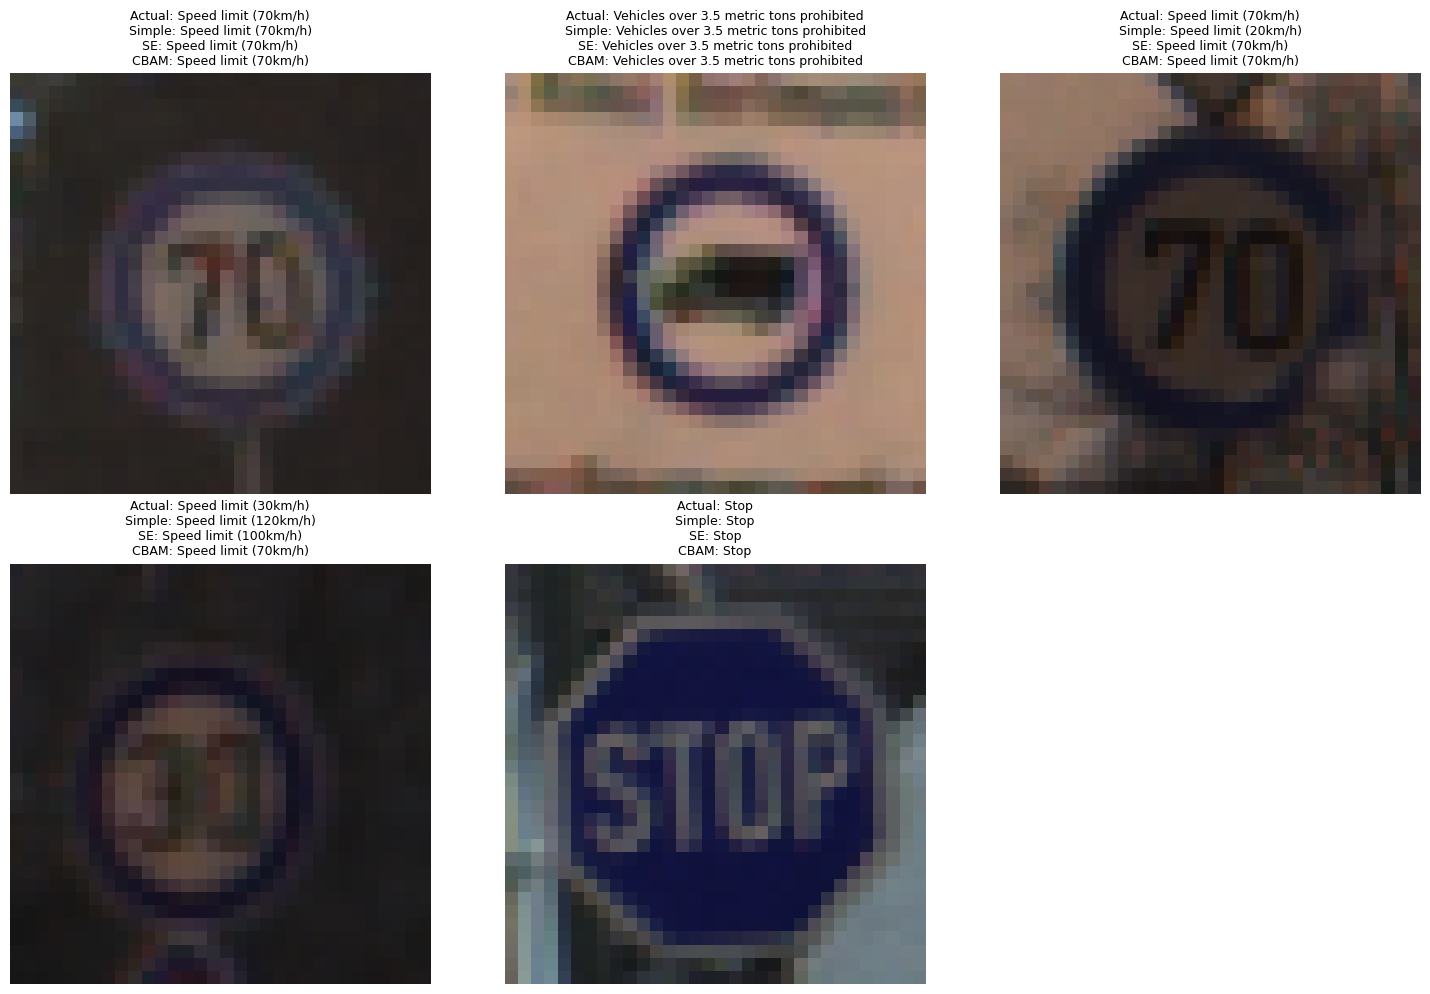

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Pick 5 random test images
num_images = 5
random_indices = random.sample(range(len(test_images)), num_images)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    img = test_images[idx]
    actual_id = actual[idx]

    # Predict with each model
    simple_pred = np.argmax(model_simple.predict(img.reshape(1,32,32,3)))
    se_pred = np.argmax(model_se.predict(img.reshape(1,32,32,3)))
    cbam_pred = np.argmax(model_cbam.predict(img.reshape(1,32,32,3)))

    # Plot
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Actual: {class_names[actual_id]}\nSimple: {class_names[simple_pred]}\nSE: {class_names[se_pred]}\nCBAM: {class_names[cbam_pred]}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Predict all test images with each model
pred_simple = np.argmax(model_simple.predict(test_images), axis=1)
pred_se = np.argmax(model_se.predict(test_images), axis=1)
pred_cbam = np.argmax(model_cbam.predict(test_images), axis=1)

# Calculate number of wrong predictions
simple_mistakes = np.sum(pred_simple != actual)
se_mistakes = np.sum(pred_se != actual)
cbam_mistakes = np.sum(pred_cbam != actual)

# Print the results
print(f"Simple Attention Mistakes: {simple_mistakes}")
print(f"SE Attention Mistakes: {se_mistakes}")
print(f"CBAM Attention Mistakes: {cbam_mistakes}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Simple Attention Mistakes: 1912
SE Attention Mistakes: 466
CBAM Attention Mistakes: 604
